date : tarih
active_power : kullanılan güç
current : akım
voltage : voltaj 
reactive_power : Manyetik alanlarda geçici depolanan iş yapmayan güç
apparent_power : Toplam güç; hem gerçek hem reaktif gücün birleşimi
power_factor : Gerçek gücün, görünen güce oranı ; Enerji verimliliğini verir
main : hava durumu
description : Biraz daha detaylı hava durumu (açık hava, kapalı hava)
temp : sıcaklık
feels_like : hissedilen sıcaklık
temp_min : minimum sıcaklık
temp_max : maximum sıcaklık
pressure : basınç
humidity : nem
speed : rüzgar hızı
deg : Rüzgar yönü
temp_t+1 : Ertesi günün sıcaklık tahmini
feels_like_t+1 : Ertesi günün hissedilen sıcaklığı

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
import xgboost as xg_boost
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import joblib

df = pd.read_csv("energy_weather_raw_data.csv")

print(df.columns)
display(df)
display(df.describe)
display(df.info())
for sütun in df.columns:
    print(df[sütun].isnull().sum())
sayisal_sutunlar = df.select_dtypes(include=np.number).columns
for sutun in sayisal_sutunlar:
    data_sutun = df[sütun]
    Q1 = data_sutun.quantile(0.25)
    Q3 = data_sutun.quantile(0.75)
    IQR = Q3 - Q1

    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    print(f"  Q1 Değeri: {Q1:.2f}")
    print(f"  Q3 Değeri: {Q3:.2f}")
    print(f"  IQR Değeri: {IQR:.2f}")
    print(f"  Aykırı Değer Alt Sınırı: {alt_sinir:.2f}")
    print(f"  Aykırı Değer Üst Sınırı: {ust_sinir:.2f}")

Index(['date', 'active_power', 'current', 'voltage', 'reactive_power',
       'apparent_power', 'power_factor', 'main', 'description', 'temp',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed',
       'deg', 'temp_t+1', 'feels_like_t+1'],
      dtype='object')


,date,active_power,current,voltage,reactive_power,apparent_power,power_factor,main,description,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
0,2022-11-05 14:05:00,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
1,2022-11-05 14:06:00,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
2,2022-11-05 14:07:00,265.1,2.53,122.2,159.09,309.17,0.8575,Clear,clear sky,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
3,2022-11-05 14:08:00,640.0,5.45,120.7,152.08,657.82,0.9729,Clear,clear sky,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
4,2022-11-05 14:09:00,257.6,2.47,122.4,158.26,302.33,0.8520,Clear,clear sky,24.19,23.68,23.44,27.50,1013,39,0.00,0,29.63,27.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605255,2024-01-05 23:55:00,316.3,2.53,129.1,81.46,326.62,0.9684,Clouds,few clouds,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.99,12.75
605256,2024-01-05 23:56:00,1526.3,13.58,124.8,736.67,1694.78,0.9006,Clouds,few clouds,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,12.75
605257,2024-01-05 23:57:00,1528.7,13.56,124.9,729.04,1693.64,0.9026,Clouds,few clouds,12.32,10.65,8.07,13.96,1012,40,2.05,160,13.96,12.72
605258,2024-01-05 23:58:00,283.4,2.26,129.6,73.99,292.90,0.9676,Clouds,few clouds,12.76,11.11,8.07,13.96,1012,39,2.05,160,13.99,12.75


<bound method NDFrame.describe of                        date  active_power  current  voltage  reactive_power  \
0       2022-11-05 14:05:00         265.1     2.53    122.2          159.09   
1       2022-11-05 14:06:00         265.1     2.53    122.2          159.09   
2       2022-11-05 14:07:00         265.1     2.53    122.2          159.09   
3       2022-11-05 14:08:00         640.0     5.45    120.7          152.08   
4       2022-11-05 14:09:00         257.6     2.47    122.4          158.26   
...                     ...           ...      ...      ...             ...   
605255  2024-01-05 23:55:00         316.3     2.53    129.1           81.46   
605256  2024-01-05 23:56:00        1526.3    13.58    124.8          736.67   
605257  2024-01-05 23:57:00        1528.7    13.56    124.9          729.04   
605258  2024-01-05 23:58:00         283.4     2.26    129.6           73.99   
605259  2024-01-05 23:59:00         283.4     2.26    129.6           73.99   

        apparent_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605260 entries, 0 to 605259
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            605260 non-null  object 
 1   active_power    605260 non-null  float64
 2   current         605260 non-null  float64
 3   voltage         605260 non-null  float64
 4   reactive_power  605260 non-null  float64
 5   apparent_power  605260 non-null  float64
 6   power_factor    605260 non-null  float64
 7   main            605260 non-null  object 
 8   description     605260 non-null  object 
 9   temp            605260 non-null  float64
 10  feels_like      605260 non-null  float64
 11  temp_min        605260 non-null  float64
 12  temp_max        605260 non-null  float64
 13  pressure        605260 non-null  int64  
 14  humidity        605260 non-null  int64  
 15  speed           605260 non-null  float64
 16  deg             605260 non-null  int64  
 17  temp_t+1  

None

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı Değer Üst Sınırı: 38.75
  Q1 Değeri: 13.92
  Q3 Değeri: 23.85
  IQR Değeri: 9.93
  Aykırı Değer Alt Sınırı: -0.98
  Aykırı De

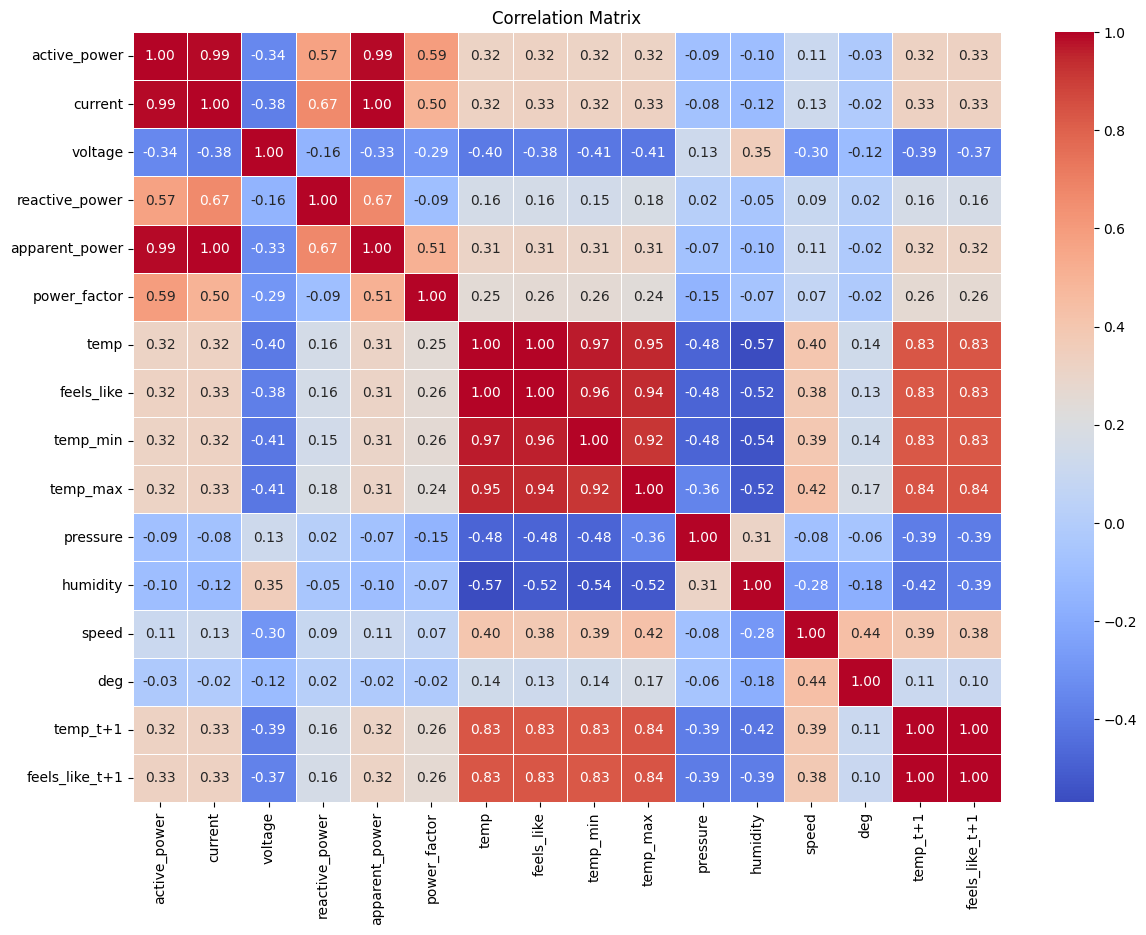

In [2]:
sayisal_sutunlar = df.select_dtypes(include='number')  
korelasyon = sayisal_sutunlar.corr()
plt.figure(figsize=(14,10))
sns.heatmap(korelasyon, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

C:\Users\emirc\AppData\Local\Temp\ipykernel_2528\1919513958.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='temp_bin', y='humidity', data=df, palette='coolwarm')


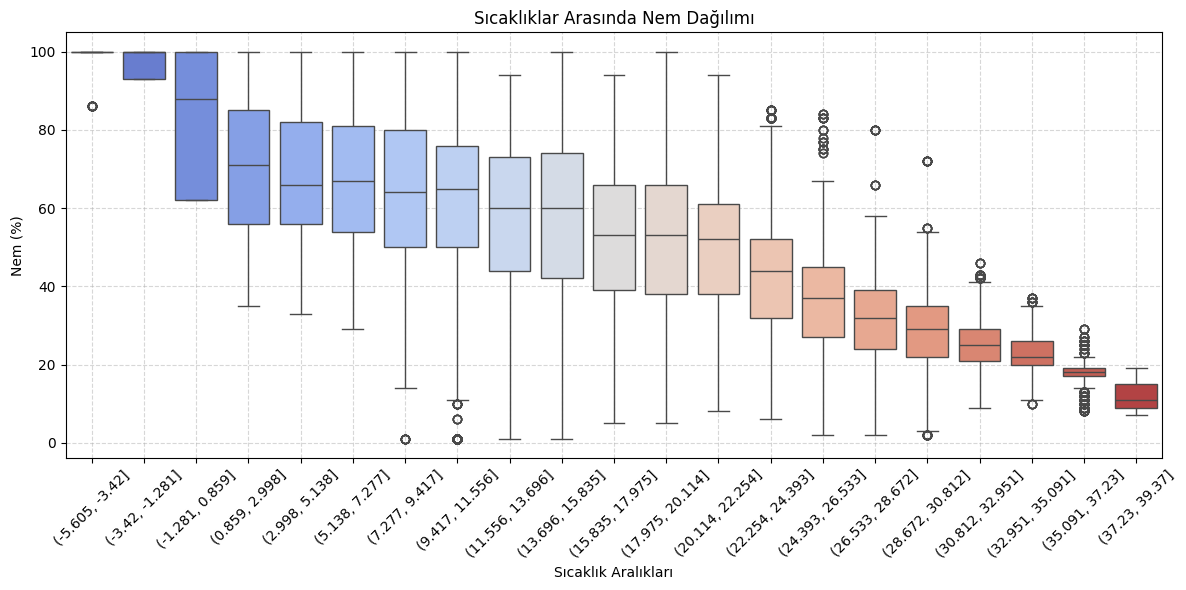

In [3]:
n = len(df['temp'].dropna())
k = math.ceil(np.log2(n) + 1)
df['temp_bin'] = pd.cut(df['temp'], bins=k)

plt.figure(figsize=(12, 6))
sns.boxplot(x='temp_bin', y='humidity', data=df, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Sıcaklıklar Arasında Nem Dağılımı')
plt.xlabel('Sıcaklık Aralıkları')
plt.ylabel('Nem (%)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('sicaklik_nem_dagilimi.png')
plt.show()

plt.close()

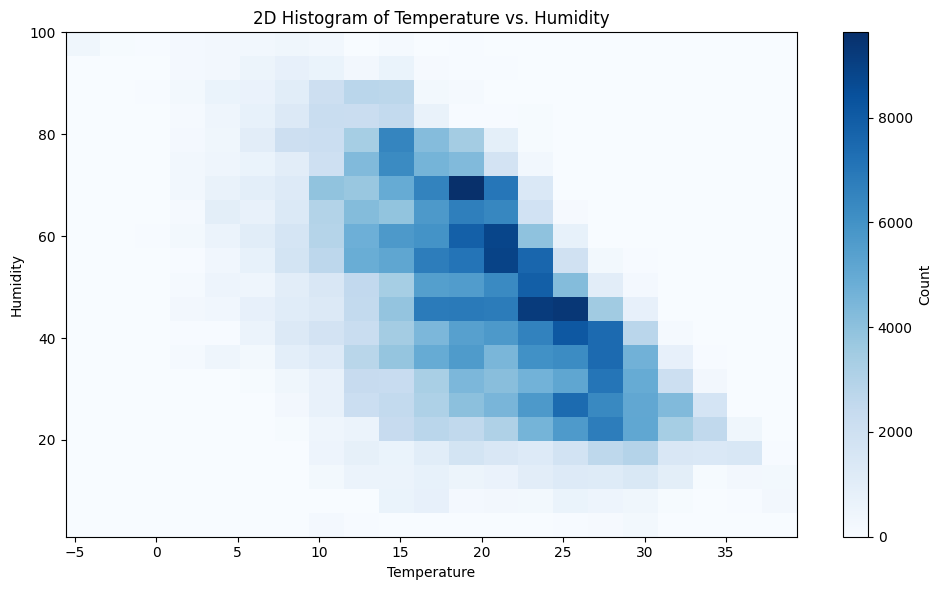

In [4]:
plt.figure(figsize=(10, 6))
plt.hist2d(df['temp'], df['humidity'], bins=(k, k), cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('2D Histogram of Temperature vs. Humidity')
plt.tight_layout()
plt.show()


In [5]:
fig2 = plt.figure(figsize=(10, 6)) # Yeni figür objesi oluşturuldu
sns.regplot(x='temp', y='humidity', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Eğilim Çizgisi ile Dağılım Grafiği: Sıcaklık ve Nem')
plt.xlabel('Sıcaklık (°C)')
plt.ylabel('Nem (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig('sicaklik_nem_dagilimi_scatter.png')
plt.close(fig2)

In [6]:
df.drop(columns=["date"])
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

In [7]:
X = df.select_dtypes(include=['float64', 'int64'])
print("Analize dahil edilen sütunlar:")
print(X.columns.tolist())
print("-" * 30)

X_with_const = add_constant(X)

print("VIF hesaplanıyor...")
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("-" * 30)

print("\nVaryans Büyütme Faktörü (VIF) Sonuçları:")
print(vif_data.to_string())


Analize dahil edilen sütunlar:
['active_power', 'current', 'voltage', 'reactive_power', 'apparent_power', 'power_factor', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed', 'deg', 'temp_t+1', 'feels_like_t+1']
------------------------------
VIF hesaplanıyor...
------------------------------

Varyans Büyütme Faktörü (VIF) Sonuçları:
           feature           VIF
0            const  48854.014236
1     active_power    934.329503
2          current    821.741400
3          voltage      3.890954
4   reactive_power     18.589156
5   apparent_power   1401.804226
6     power_factor      5.733063
7             temp    287.341776
8       feels_like    234.346525
9         temp_min     15.443829
10        temp_max     13.133446
11        pressure      1.556094
12        humidity      2.823351
13           speed      1.554970
14             deg      1.280389
15        temp_t+1    154.054724
16  feels_like_t+1    155.034471


In [8]:
columns_to_keep = ['active_power', 'current', 'voltage', 'temp', 'pressure', 'humidity', 'speed', 'deg', "description"]

df = df[columns_to_keep]
df_encoded = pd.get_dummies(df, columns=['description'],dtype='int')

df_encoded.columns = df_encoded.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

In [9]:
X = df_encoded.drop('active_power', axis=1)
y = df_encoded['active_power']

numerical_features = ['current', 'voltage', 'temp', 'pressure', 'humidity', 'speed', 'deg']
categorical_features_encoded = [col for col in X.columns if col not in numerical_features]

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

original_X_columns = X.columns
all_descriptions = df['description'].unique().tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_performance = {}

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R² Score: {r2}")
    print("-" * 50)
    model_performance[name] = {'MAE': mae, 'MSE': mse, 'R²': r2}

In [11]:
lr = LinearRegression()
evaluate_model('Linear Regression', lr)

ridge = Ridge(alpha=1.0)
evaluate_model('Ridge Regression', ridge)

lasso = Lasso(alpha=0.1)
evaluate_model('Lasso Regression', lasso)

xgb = xg_boost.XGBRegressor(random_state=42)
evaluate_model('XGBoost', xgb)

lgbm = lgb.LGBMRegressor(random_state=42)
evaluate_model('LightGBM', lgbm)

Model: Linear Regression
Mean Absolute Error: 19.92
Mean Squared Error: 683.50
R² Score: 0.9809791400624576
--------------------------------------------------
Model: Ridge Regression
Mean Absolute Error: 19.92
Mean Squared Error: 683.52
R² Score: 0.9809784603729056
--------------------------------------------------
Model: Lasso Regression
Mean Absolute Error: 19.93
Mean Squared Error: 684.10
R² Score: 0.9809623139607148
--------------------------------------------------
Model: XGBoost
Mean Absolute Error: 16.21
Mean Squared Error: 531.44
R² Score: 0.9852106251593151
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 484208, number of used features: 21
[LightGBM] [Info] Star

In [12]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
evaluate_model('Random Forest', rf)

Model: Random Forest
Mean Absolute Error: 9.05
Mean Squared Error: 188.33
R² Score: 0.9947590111470462
--------------------------------------------------


In [13]:
param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso Regression': {'alpha': [0.01, 0.1, 1.0]},
    'Random Forest': {'n_estimators': [100], 'max_depth': [15, 20]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [5, 7]}
}

models_to_tune = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': xg_boost.XGBRegressor(random_state=42)
}

best_estimators = {}

for name, model in models_to_tune.items():
    if name in param_grids:
        print(f"--- {name} için Optimizasyon ---")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], 
                                   cv=3, n_jobs=-1, scoring='r2', verbose=0)
        grid_search.fit(X_train, y_train)
        
        print(f"En iyi parametreler: {grid_search.best_params_}")
        
        best_estimators[name] = grid_search.best_estimator_
        evaluate_model(f'{name} (Optimize Edilmiş)', best_estimators[name])

--- Ridge Regression için Optimizasyon ---
En iyi parametreler: {'alpha': 0.1}
Model: Ridge Regression (Optimize Edilmiş)
Mean Absolute Error: 19.92
Mean Squared Error: 683.52
R² Score: 0.9809784650827581
--------------------------------------------------
--- Lasso Regression için Optimizasyon ---
En iyi parametreler: {'alpha': 0.01}
Model: Lasso Regression (Optimize Edilmiş)
Mean Absolute Error: 19.92
Mean Squared Error: 683.60
R² Score: 0.98097618920378
--------------------------------------------------
--- Random Forest için Optimizasyon ---
En iyi parametreler: {'max_depth': 20, 'n_estimators': 100}
Model: Random Forest (Optimize Edilmiş)
Mean Absolute Error: 3.47
Mean Squared Error: 64.82
R² Score: 0.9981962296179606
--------------------------------------------------
--- LightGBM için Optimizasyon ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [14]:
performance_df = pd.DataFrame(model_performance).T
print("\n--- Tüm Modellerin Performans Karşılaştırması ---")
print(performance_df.sort_values(by='R²', ascending=False))


--- Tüm Modellerin Performans Karşılaştırması ---
                                           MAE         MSE        R²
Random Forest (Optimize Edilmiş)      3.472433   64.816713  0.998196
Random Forest                         9.046124  188.329775  0.994759
XGBoost (Optimize Edilmiş)           15.718242  501.504253  0.986044
LightGBM (Optimize Edilmiş)          16.756946  514.437641  0.985684
XGBoost                              16.213803  531.441626  0.985211
LightGBM                             17.443717  551.804059  0.984644
Linear Regression                    19.919185  683.495878  0.980979
Ridge Regression (Optimize Edilmiş)  19.919496  683.520133  0.980978
Ridge Regression                     19.919643  683.520302  0.980978
Lasso Regression (Optimize Edilmiş)  19.920514  683.601914  0.980976
Lasso Regression                     19.926152  684.100507  0.980962


In [15]:
rfr_best = best_estimators.get('Random Forest')
lgbm_best = best_estimators.get('LightGBM')
xgb_best = best_estimators.get('XGBoost')

voting_regressor = VotingRegressor(
    estimators=[
        ('Random Forest', rfr_best),
        ('LightGBM', lgbm_best),
        ('XGBoost', xgb_best)
    ],
    n_jobs=-1
)

evaluate_model('Ensemble Learning', voting_regressor)

estimators = [('Random Forest', rfr_best), ('LightGBM', lgbm_best), ('XGBoost', xgb_best)]
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0), # Meta-model
    cv=5,
    n_jobs=-1
)
evaluate_model('Ensemble (Stacking)', stacking_regressor)

Model: Ensemble Learning
Mean Absolute Error: 11.74
Mean Squared Error: 264.11
R² Score: 0.9926500004284131
--------------------------------------------------
Model: Ensemble (Stacking)
Mean Absolute Error: 3.30
Mean Squared Error: 60.10
R² Score: 0.998327498616967
--------------------------------------------------


In [16]:
joblib.dump(lr, 'lr.joblib', compress='zlib')
print("Lineer Regresyon modeli 'lr.joblib' olarak kaydedildi.")

joblib.dump(scaler, 'scaler.joblib')
print("StandardScaler 'scaler.joblib' olarak kaydedildi.")

joblib.dump(original_X_columns, 'original_X_columns.joblib')
print("Orijinal özellik sütunları 'original_X_columns.joblib' olarak kaydedildi.")

joblib.dump(all_descriptions, 'all_descriptions.joblib')
print("Tüm description değerleri 'all_descriptions.joblib' olarak kaydedildi.")

joblib.dump(numerical_features, 'numerical_features.joblib')
print("Sayısal özellikler 'numerical_features.joblib' olarak kaydedildi.")


Lineer Regresyon modeli 'lr.joblib' olarak kaydedildi.
StandardScaler 'scaler.joblib' olarak kaydedildi.
Orijinal özellik sütunları 'original_X_columns.joblib' olarak kaydedildi.
Tüm description değerleri 'all_descriptions.joblib' olarak kaydedildi.
Sayısal özellikler 'numerical_features.joblib' olarak kaydedildi.


In [17]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.3, random_state=42)

lr_new = LinearRegression()
lr_new.fit(X_train_new, y_train_new)

y_train_pred_new = lr_new.predict(X_train_new)
y_test_pred_new = lr_new.predict(X_test_new)

train_r2_new = r2_score(y_train_new, y_train_pred_new)
test_r2_new = r2_score(y_test_new, y_test_pred_new)

print(f"Lineer Regresyon - Eğitim R² Skoru: {train_r2_new:.2f}")
print(f"Lineer Regresyon - Test R² Skoru: {test_r2_new:.2f}")


Lineer Regresyon - Eğitim R² Skoru: 0.98
Lineer Regresyon - Test R² Skoru: 0.98


In [18]:
print("\n--- Lineer Regresyon için Çapraz Doğrulama ---")
cv_scores = cross_val_score(lr_new, X, y, cv=5, scoring='r2', n_jobs=-1)

print(f"5 Katlı Çapraz Doğrulama R² Skorları: {cv_scores}")


--- Lineer Regresyon için Çapraz Doğrulama ---
5 Katlı Çapraz Doğrulama R² Skorları: [ 9.78039226e-01  9.70815090e-01 -5.33417829e+16  9.78532166e-01
  9.68678447e-01]


In [19]:
print(df.head(1))

   active_power  current  voltage   temp  pressure  humidity  speed  deg  \
0         265.1     2.53    122.2  24.19      1013        39    0.0    0   

  description  
0   clear sky  
